# Genetic Algorithms (GA)

In [1]:
#install necessary libraries
!pip install deap


In [2]:
#import necessary libraries
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from deap import base, creator, tools
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split



In [3]:
df = pd.read_csv(
    'cleaned_smart_bin_data.csv'
)

# Keep bin_id separately
bin_ids = df['bin_id']

In [4]:
# Keep 3-class label as-is
# 0 = Low, 1 = Medium, 2 = High
y = df['priority_label']

X = df.drop(['priority_label'], axis=1)

X_train, X_test, y_train, y_test, bin_id_train, bin_id_test = train_test_split(
    X, y, bin_ids,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape)
print("Test:", X_test.shape)

Train: (81, 6)
Test: (36, 6)


In [5]:
def discretize_fill(x):
    if x < 60:
        return 0   # Low
    elif x < 85:
        return 1   # Medium
    else:
        return 2   # High

def discretize_battery(x):
    if x < 30:
        return 0
    elif x < 70:
        return 1
    else:
        return 2

def discretize_time(x):
    if x < 0.3:
        return 0   # Recent
    elif x < 0.7:
        return 1   # Moderate
    else:
        return 2   # Long

In [6]:
# GA REPRESENTATION

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Rule structure:
# [fill, battery, overflow, time, status, priority, score]
def random_rule():
    return [
        random.choice([-1, 0, 1, 2]),  # fill
        random.choice([-1, 0, 1, 2]),  # battery
        random.choice([-1, 0, 1]),     # overflow
        random.choice([-1, 0, 1, 2]),  # time
        random.choice([-1, 0, 1, 2]),  # status
        random.randint(0, 2),          # priority (0/1/2) - now 3 classes
        random.uniform(0, 1)           # score
    ]

def init_individual(n_rules=6):
    return creator.Individual([random_rule() for _ in range(n_rules)])

In [7]:
#  RULE MATCHING & INFERENCE

def match_rule(rule, row):
    conditions = [
        (rule[0], discretize_fill(row['fill_level_percent'])),
        (rule[1], discretize_battery(row['battery_level_percent'])),
        (rule[2], row['overflow_alert']),
        (rule[3], discretize_time(row['time_since_last_reading_norm'])),
        (rule[4], row['bin_status_encoded'])
    ]

    for rule_val, data_val in conditions:
        if rule_val != -1 and rule_val != data_val:
            return False

    return True


def ga_infer(row, rules):
    matched = [r for r in rules if match_rule(r, row)]

    if not matched:
        return 0, 0.0

    # Find highest priority among matched rules
    # Group rules by priority level
    priority_2_rules = [r for r in matched if r[5] == 2]  # High priority
    priority_1_rules = [r for r in matched if r[5] == 1]  # Medium priority
    priority_0_rules = [r for r in matched if r[5] == 0]  # Low priority

    if priority_2_rules:
        best = max(priority_2_rules, key=lambda r: r[6])
        return 2, best[6]
    elif priority_1_rules:
        best = max(priority_1_rules, key=lambda r: r[6])
        return 1, best[6]
    else:
        best = max(priority_0_rules, key=lambda r: r[6])
        return 0, best[6] * 0.5

In [8]:
# FITNESS FUNCTION (MULTI-CLASS F1)
from sklearn.metrics import f1_score
def evaluate(individual, X, y):
    preds = []

    for _, row in X.iterrows():
        p, _ = ga_infer(row, individual)
        preds.append(p)

    # Use weighted F1 score for 3-class problem
    f1 = f1_score(y, preds, average='weighted', zero_division=0)

    # Penalize too many don't-cares
    dont_care_penalty = sum(rule.count(-1) for rule in individual) * 0.001

    return (f1 - dont_care_penalty,)

In [9]:
toolbox = base.Toolbox()

toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evaluate, X=X_train, y=y_train)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

In [10]:
# TRAIN GA
population = toolbox.population(n=50)
NGEN = 30

for gen in range(NGEN):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.7:
            toolbox.mate(c1, c2)
            del c1.fitness.values, c2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    invalid = [ind for ind in offspring if not ind.fitness.valid]
    for ind, fit in zip(invalid, map(toolbox.evaluate, invalid)):
        ind.fitness.values = fit

    population[:] = offspring

best_ind = tools.selBest(population, 1)[0]


In [11]:
# TRAINING SET EVALUATION
y_train_pred = []

for _, row in X_train.iterrows():
    p, _ = ga_infer(row, best_ind)
    y_train_pred.append(p)

print("GA Training Accuracy:", accuracy_score(y_train, y_train_pred))
print("GA Training Classification Report:")
print(classification_report(y_train, y_train_pred))


GA Training Accuracy: 0.6790123456790124
GA Training Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.75        40
           1       0.00      0.00      0.00        16
           2       1.00      0.60      0.75        25

    accuracy                           0.68        81
   macro avg       0.54      0.53      0.50        81
weighted avg       0.61      0.68      0.60        81



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


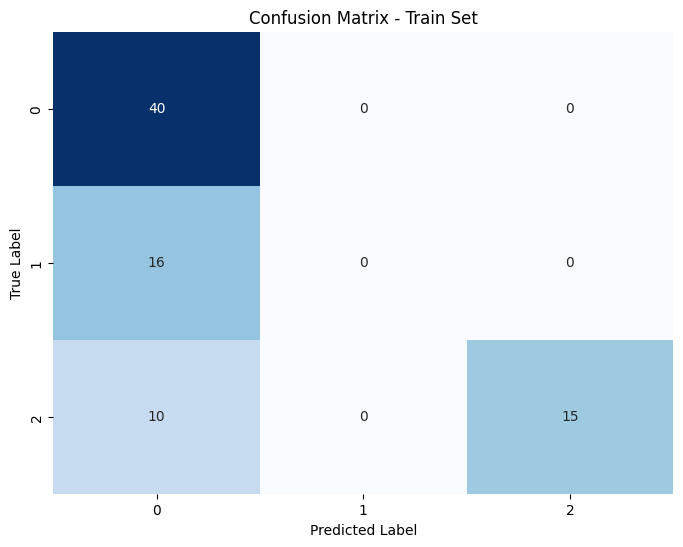

In [13]:
cm_train_3class = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train_3class, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1', '2'],
            yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Train Set')
plt.show()

In [14]:
# EVALUATION

y_pred = []
scores = []

for _, row in X_test.iterrows():
    p, s = ga_infer(row, best_ind)
    y_pred.append(p)
    scores.append(s)

print("GA Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


GA Accuracy: 0.7222222222222222
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        18
           1       0.00      0.00      0.00         7
           2       1.00      0.73      0.84        11

    accuracy                           0.72        36
   macro avg       0.55      0.58      0.54        36
weighted avg       0.63      0.72      0.65        36



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


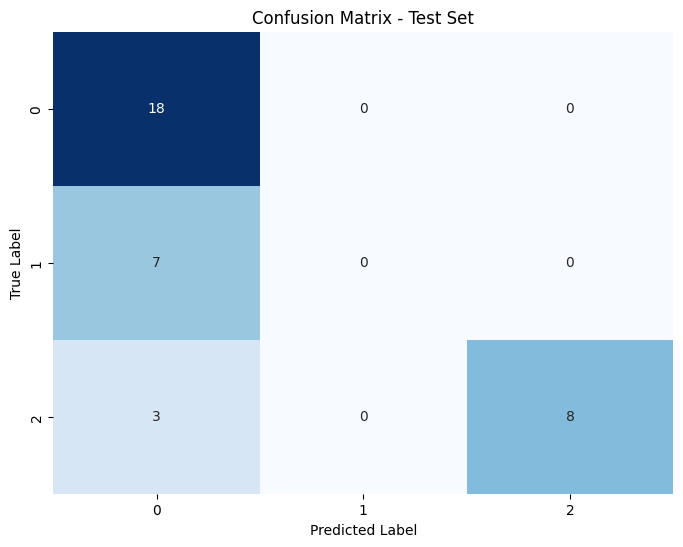

In [15]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['0', '1', '2'],
            yticklabels=['0', '1', '2'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Set')
plt.show()

In [16]:
#print top 10 bins with the highest priority
results = X_test.copy()
results['bin_id'] = bin_id_test.values
results['priority'] = y_pred
results['score'] = scores

top_10 = results.sort_values(
    by='score',
    ascending=False
).head(10)

print(top_10[['bin_id', 'priority', 'score']])

      bin_id  priority     score
81   BIN-134         2  0.642434
74   BIN-127         2  0.642434
71   BIN-124         2  0.642434
51   BIN-103         2  0.642434
97   BIN-150         2  0.642434
99   BIN-202         2  0.609804
25   BIN-026         2  0.609804
114  BIN-217         2  0.609804
92   BIN-145         0  0.000000
14   BIN-015         0  0.000000
